<a href="https://colab.research.google.com/github/Oanh0305/CSCA-5642_week5_project/blob/main/Monet_CycleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 'gan-getting-started'

100% 367M/367M [00:21<00:00, 20.0MB/s]
100% 367M/367M [00:21<00:00, 17.6MB/s]


In [ ]:
! ls

gan-getting-started.zip  gdrive  kaggle.json  sample_data


In [ ]:
! unzip gan-getting-started.zip

In [ ]:
!ls monet_tfrec

monet00-60.tfrec  monet04-60.tfrec  monet08-60.tfrec  monet12-60.tfrec	monet16-60.tfrec


# Monet CycleGan

## 1. Description of the problem and data

* The challange is build a GAN that generates 7,000 to 10,000 Monet-style images.
* The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.
* Files
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
! pip install tensorflow-addons
import tensorflow_addons as tfa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
! pip install git+https://github.com/tensorflow/examples.git
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-f2neou0c
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-f2neou0c
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.15.0


## 2. Inspect, Visualize and Clean the Data

Load in data

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob('monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Scale the images to a [-1, 1] scale

In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

 Visualize a photo example and a Monet example

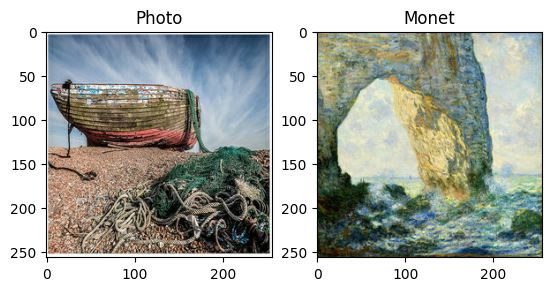

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## 3. Build the CycleGAN model

We'll be using a UNET architecture for our CycleGAN

In [ ]:
OUTPUT_CHANNELS = 3

monet_generator = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
photo_generator  = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

monet_discriminator = pix2pix.discriminator(norm_type='instancenorm', target=False)
photo_discriminator = pix2pix.discriminator(norm_type='instancenorm', target=False)

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

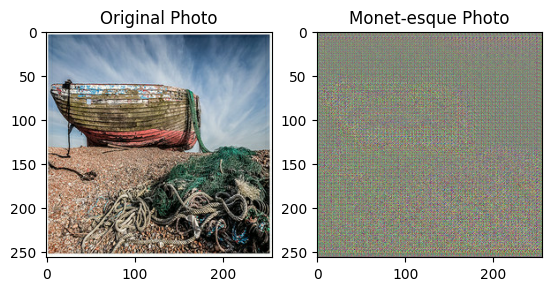

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
             # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
         # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


Define loss functions¶


In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

Train the CycleGAN

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 94s 163ms/step - monet_gen_loss: 5.4750 - photo_gen_loss: 5.5372 - monet_disc_loss: 0.6906 - photo_disc_loss: 0.6954
Epoch 2/25
300/300 [==============================] - 48s 161ms/step - monet_gen_loss: 3.7731 - photo_gen_loss: 3.7760 - monet_disc_loss: 0.6492 - photo_disc_loss: 0.6582
Epoch 3/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.5036 - photo_gen_loss: 3.5257 - monet_disc_loss: 0.6451 - photo_disc_loss: 0.6520
Epoch 4/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.3520 - photo_gen_loss: 3.3828 - monet_disc_loss: 0.6413 - photo_disc_loss: 0.6463
Epoch 5/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.2059 - photo_gen_loss: 3.2450 - monet_disc_loss: 0.6361 - photo_disc_loss: 0.6418
Epoch 6/25
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.0726 - photo_gen_loss: 3.1155 - monet_disc_loss: 0.6313 

## 4. Visualize our Monet-esque photos

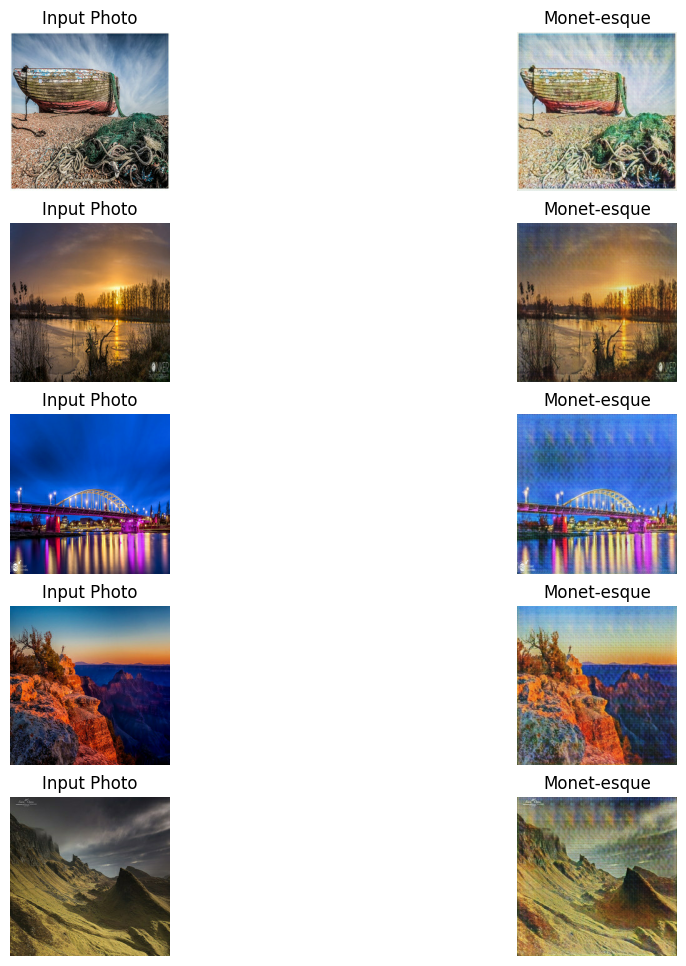

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## 5. Create submission file

In [ ]:
import PIL
! mkdir images


In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

In [ ]:
!zip -r images.zip images

Streaming output truncated to the last 5000 lines.
  adding: images/2838.jpg (deflated 1%)
  adding: images/2572.jpg (deflated 1%)
  adding: images/357.jpg (deflated 1%)
  adding: images/451.jpg (deflated 1%)
  adding: images/5541.jpg (deflated 1%)
  adding: images/416.jpg (deflated 1%)
  adding: images/3067.jpg (deflated 1%)
  adding: images/4518.jpg (deflated 1%)
  adding: images/3212.jpg (deflated 1%)
  adding: images/5494.jpg (deflated 1%)
  adding: images/6411.jpg (deflated 2%)
  adding: images/354.jpg (deflated 1%)
  adding: images/4688.jpg (deflated 2%)
  adding: images/5309.jpg (deflated 1%)
  adding: images/3906.jpg (deflated 1%)
  adding: images/365.jpg (deflated 2%)
  adding: images/4399.jpg (deflated 2%)
  adding: images/1899.jpg (deflated 1%)
  adding: images/672.jpg (deflated 1%)
  adding: images/4557.jpg (deflated 1%)
  adding: images/1194.jpg (deflated 1%)
  adding: images/2359.jpg (deflated 1%)
  adding: images/1927.jpg (deflated 1%)
  adding: images/1888.jpg (deflated

In [ ]:
! ls

gan-getting-started.zip  images      kaggle.json  monet_tfrec  photo_tfrec
gdrive			 images.zip  monet_jpg	  photo_jpg    sample_data


In [ ]:
from google.colab import files

files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>